In [1]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
import numpy as np

from qiskit.circuit import QuantumCircuit, ClassicalRegister, QuantumRegister, Qubit, Gate, Parameter, ParameterVector
from qiskit.tools.visualization import circuit_drawer 
from qiskit import Aer, execute
from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit.quantum_info import Operator, Pauli
from qiskit.opflow import PauliOp, SummedOp, ComposedOp
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn, AerPauliExpectation, MatrixExpectation
from qiskit.algorithms import MinimumEigensolver, NumPyMinimumEigensolver, VQE

import itertools

In [2]:
##Qubits on Lattice, Lattice Parameters
qubits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
Nq = len(qubits)

xx_links = [(1, 14), (2, 13), (12, 19), (5, 10), (6, 9), (17, 22), (18, 21), (15, 16)]
yy_links = [(1, 2), (3, 4), (5, 6), (10, 9), (12, 11), (14, 13), (17, 18), (22, 21)]
yy_links_reversed = [(22, 21), (17, 18), (14, 13), (12, 11), (10, 9), (5, 6), (3, 4), (1, 2)]
zz_links = [(0, 1), (2, 3), (4, 5), (6, 7), (9, 8), (11, 10), (13, 12), (15, 14), (16, 17), (18, 19), (21, 20), (23, 22)]
zz_links_reversed = [(23, 22), (21, 20), (18, 19), (16, 17), (15, 14), (13, 12), (11, 10), (9, 8), (6, 7), (4, 5), (2, 3), (0, 1)]

Jx, Jy, Jz = -1.0/np.sqrt(2), -1.0/np.sqrt(2), -1.0
hX = hY = hZ = 0.05/np.sqrt(3)

In [3]:
##Hamiltonian Construction (Square-Octagon Model)

#Construct Pauli strings
XX_links_strings = []
for (i,j) in xx_links:
    XX_string = ""
    for q in range(Nq):
        if q != i and q != j:
            XX_string += 'I'
        else:
            XX_string += 'X'
    XX_links_strings.append(XX_string)
    
YY_links_strings = []
for (i,j) in yy_links:
    YY_string = ""
    for q in range(Nq):
        if q != i and q != j:
            YY_string += 'I'
        else:
            YY_string += 'Y'
    YY_links_strings.append(YY_string)

ZZ_links_strings = []
for (i,j) in zz_links:
    ZZ_string = ""
    for q in range(Nq):
        if q != i and q != j:
            ZZ_string += 'I'
        else:
            ZZ_string += 'Z'
    ZZ_links_strings.append(ZZ_string)

X_qubit_strings = []
Y_qubit_strings = []
Z_qubit_strings = []
for k in qubits:
    X_string = ""
    Y_string = ""
    Z_string = ""
    for q in range(Nq):
        if q != k:
            X_string += 'I'
            Y_string += 'I'
            Z_string += 'I'
        else:
            X_string += 'X'
            Y_string += 'Y'
            Z_string += 'Z'
    X_qubit_strings.append(X_string)
    Y_qubit_strings.append(Y_string)
    Z_qubit_strings.append(Z_string)

In [4]:
##Hamiltonian Construction (Square-Octagon Model) (ctd.)

#Construct individual terms of Hamiltonian as Nq-qubit Pauli Operators
XX_links_terms = []
YY_links_terms = []
ZZ_links_terms = []
for i in XX_links_strings:
    XX_links_terms.append(PauliOp(Pauli(i), coeff=float(Jx)))
for i in YY_links_strings:
    YY_links_terms.append(PauliOp(Pauli(i), coeff=float(Jy)))
for i in ZZ_links_strings:
    ZZ_links_terms.append(PauliOp(Pauli(i), coeff=float(Jz)))
    
X_qubit_terms = []
Y_qubit_terms = []
Z_qubit_terms = []
for i in X_qubit_strings:
    X_qubit_terms.append(PauliOp(Pauli(i), coeff=float(hX)))
for i in Y_qubit_strings:
    Y_qubit_terms.append(PauliOp(Pauli(i), coeff=float(hY)))
for i in Z_qubit_strings:
    Z_qubit_terms.append(PauliOp(Pauli(i), coeff=float(hZ)))
    
#Construct Hamiltonian (for running with built-in VQE)
Hamiltonian = 0
for i in XX_links_terms:
    Hamiltonian += i
for i in YY_links_terms:
    Hamiltonian += i
for i in ZZ_links_terms:
    Hamiltonian += i
for i in X_qubit_terms:
    Hamiltonian += i
for i in Y_qubit_terms:
    Hamiltonian += i
for i in Z_qubit_terms:
    Hamiltonian += i

In [5]:
#Save Hamiltonian Details to text file
print(Hamiltonian, file=open("Hamiltonian_24_Qubit_Square_Octagon_Lattice_Details.txt", "a"))

In [ ]:
##Exact Diagonalization of Hamiltonian (Square-Octagon Model)
GSEnergy = NumPyMinimumEigensolver().compute_minimum_eigenvalue(operator=Hamiltonian)
print(GSEnergy)

In [6]:
##Hamiltonian Variational Ansatz Circuit Construction
def HVA_circuit(n_layers):
    global xx_links
    global yy_links
    global zz_links
    global qubits
    #Declare variational parameters
    alpha_mag = ParameterVector(r'$\tilde{\alpha}$', n_layers)
    beta_mag = ParameterVector(r'$\tilde{\beta}$', n_layers)
    gamma_mag = ParameterVector(r'$\tilde{\gamma}$', n_layers)
    alpha = ParameterVector(r'$\alpha$', n_layers)
    beta = ParameterVector(r'$\beta$', n_layers)
    gamma = ParameterVector(r'$\gamma$', n_layers)
    #Initialize circuit
    HVA = QuantumCircuit(Nq)
    for idx_layer in range(n_layers):
    #Construct X-terms portion of layer
        for q in qubits:
            HVA.rx(2*alpha_mag[idx_layer], q)
        for (i,j) in xx_links:
            HVA.h(i)
            HVA.h(j)
            HVA.cx(max(i,j), min(i,j))
            HVA.rz(2*alpha[idx_layer], min(i,j))
            HVA.cx(max(i,j), min(i,j))
            HVA.h(i)
            HVA.h(j)
        HVA.barrier()
    #Construct Y-terms portion of layer
        for q in qubits:
            HVA.ry(2*beta_mag[idx_layer], q)
        for (i,j) in yy_links:
            HVA.rx(np.pi/2, i)
            HVA.rx(np.pi/2, j)
            HVA.cx(max(i,j), min(i,j))
        for (i,j) in yy_links_reversed:
            HVA.rz(2*beta[idx_layer], min(i,j))
            HVA.cx(max(i,j), min(i,j))
            HVA.rx(-np.pi/2,i)
            HVA.rx(-np.pi/2,j)
        HVA.barrier()
    #Construct Z-terms portion of layer
        for q in qubits:
            HVA.rz(2*gamma_mag[idx_layer], q)
        for (i,j) in zz_links:
            HVA.cx(max(i,j), min(i,j))
        for (i,j) in zz_links_reversed:
            HVA.rz(2*gamma[idx_layer], min(i,j))
            HVA.cx(max(i,j), min(i,j))
        HVA.barrier()
    return HVA

In [7]:
#Save HVA Circuit to text file (for sending to Wayne)
HVA = QuantumCircuit(Nq)
for idx_layer in range(1):
#Construct X-terms portion of layer
    for q in qubits:
        HVA.rx(2, q)
    for (i,j) in xx_links:
        HVA.h(i)
        HVA.h(j)
        HVA.cx(max(i,j), min(i,j))
        HVA.rz(2, min(i,j))
        HVA.cx(max(i,j), min(i,j))
        HVA.h(i)
        HVA.h(j)
        HVA.barrier()
#Construct Y-terms portion of layer
    for q in qubits:
        HVA.ry(2, q)
    for (i,j) in yy_links:
        HVA.rx(np.pi/2, i)
        HVA.rx(np.pi/2, j)
        HVA.cx(max(i,j), min(i,j))
    for (i,j) in yy_links_reversed:
        HVA.rz(2, min(i,j))
        HVA.cx(max(i,j), min(i,j))
        HVA.rx(-np.pi/2,i)
        HVA.rx(-np.pi/2,j)
        HVA.barrier()
#Construct Z-terms portion of layer
    for q in qubits:
        HVA.rz(2, q)
    for (i,j) in zz_links:
        HVA.cx(max(i,j), min(i,j))
    for (i,j) in zz_links_reversed:
        HVA.rz(2, min(i,j))
        HVA.cx(max(i,j), min(i,j))
        HVA.barrier()
HVA.qasm(True,"HVA_Circuit_1_Layer_24_Qubit_Square_Octagon.txt")

OPENQASM 2.0;
include "qelib1.inc";
qreg q[24];
rx(2) q[0];
rx(2) q[1];
rx(2) q[2];
rx(2) q[3];
rx(2) q[4];
rx(2) q[5];
rx(2) q[6];
rx(2) q[7];
rx(2) q[8];
rx(2) q[9];
rx(2) q[10];
rx(2) q[11];
rx(2) q[12];
rx(2) q[13];
rx(2) q[14];
rx(2) q[15];
rx(2) q[16];
rx(2) q[17];
rx(2) q[18];
rx(2) q[19];
rx(2) q[20];
rx(2) q[21];
rx(2) q[22];
rx(2) q[23];
h q[1];
h q[14];
cx q[14],q[1];
rz(2) q[1];
cx q[14],q[1];
h q[1];
h q[14];
barrier q[0],q[1],q[2],q[3],q[4],q[5],q[6],q[7],q[8],q[9],q[10],q[11],q[12],q[13],q[14],q[15],q[16],q[17],q[18],q[19],q[20],q[21],q[22],q[23];
h q[2];
h q[13];
cx q[13],q[2];
rz(2) q[2];
cx q[13],q[2];
h q[2];
h q[13];
barrier q[0],q[1],q[2],q[3],q[4],q[5],q[6],q[7],q[8],q[9],q[10],q[11],q[12],q[13],q[14],q[15],q[16],q[17],q[18],q[19],q[20],q[21],q[22],q[23];
h q[12];
h q[19];
cx q[19],q[12];
rz(2) q[12];
cx q[19],q[12];
h q[12];
h q[19];
barrier q[0],q[1],q[2],q[3],q[4],q[5],q[6],q[7],q[8],q[9],q[10],q[11],q[12],q[13],q[14],q[15],q[16],q[17],q[18],q[19],q[20],q[21],q

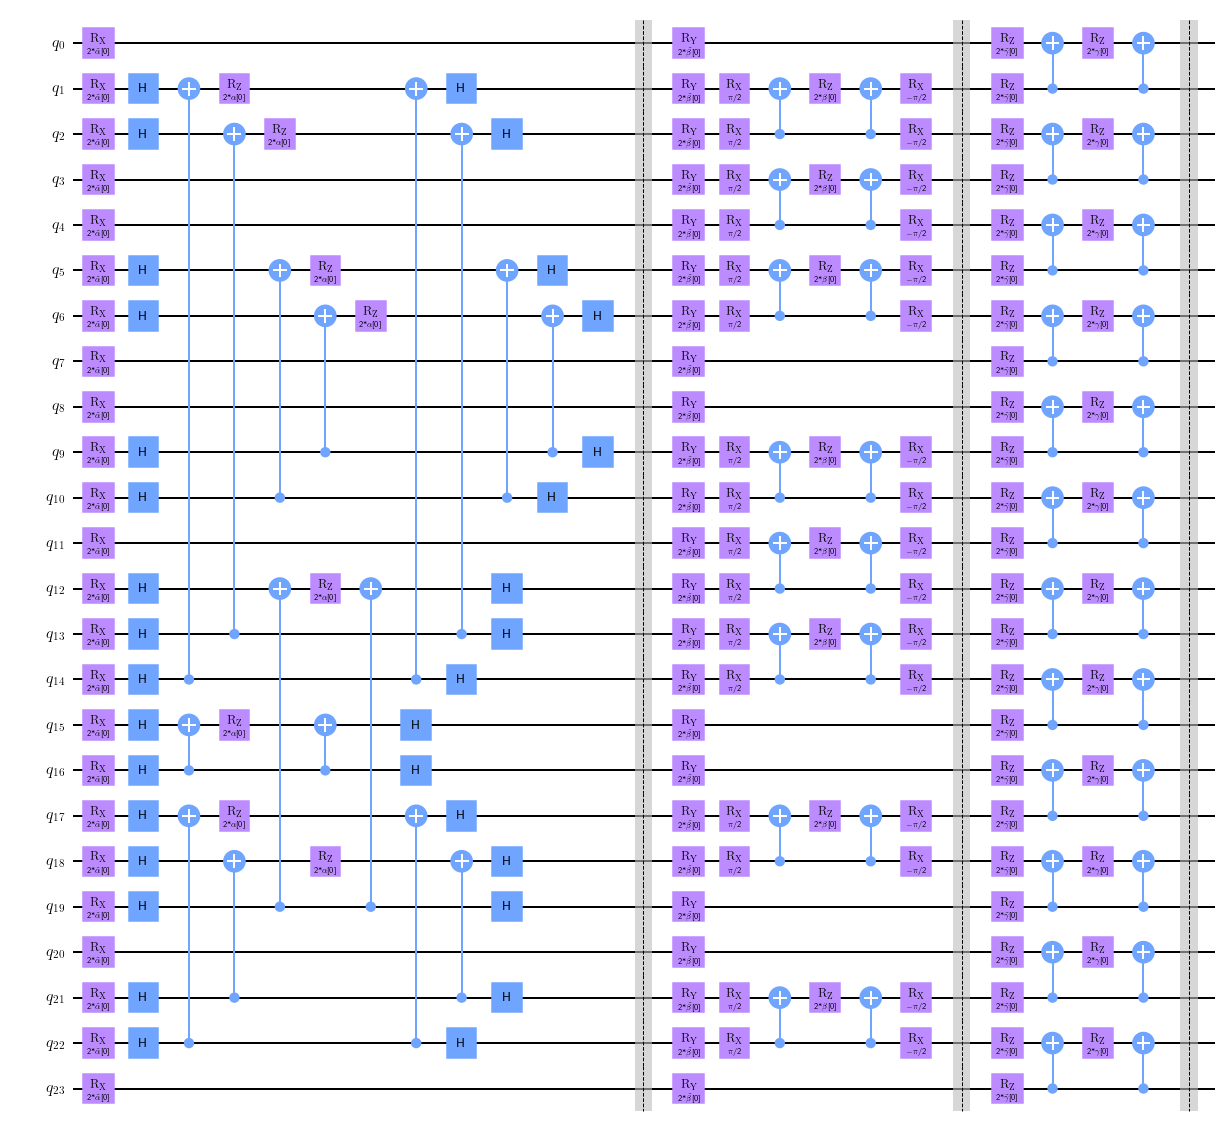

In [8]:
#Check HVA Circuit Layout
HVA_layout = HVA_circuit(1)
HVA_layout.draw('mpl', scale=None, filename='HVA_24_Qubit_Circuit_Diagram_Square_Octagon_Model')